In [23]:
from towbintools.deep_learning.deep_learning_tools import (
    create_pretrained_segmentation_model,
    create_segmentation_model,
)
from towbintools.deep_learning.utils.augmentation import (
    get_training_augmentation,
    get_prediction_augmentation,
)
from towbintools.deep_learning.utils.dataset import (
    create_segmentation_training_dataframes_and_dataloaders,
    create_segmentation_dataloaders_from_filemap,
)
import yaml
import argparse
import os
import pytorch_lightning as pl
import pytorch_lightning.callbacks as callbacks

from towbintools.deep_learning.utils.loss import FocalTverskyLoss, BCELossWithIgnore
import torch.nn as nn


def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("-c", "--config", help="Path to the config file", required=True)
    args = parser.parse_args()
    return args


config_file = "./training_config_pharynx.yaml"
with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

image_directories = config["image_directories"]
mask_directories = config["mask_directories"]
training_filemap = config.get("training_filemap", None)
save_dir = config["save_dir"]
model_name = config["model_name"]
pretrained = config.get("pretrained", True)
n_classes = config.get("n_classes", 1)
channels_to_segment = config.get("channels_to_segment", [0])
architecture = config.get("architecture", "UnetPlusPlus")
pretrained_encoder = config.get("pretrained_encoder", "efficientnet-b4")
pretrained_weights = config.get("pretrained_weights", "image-micronet")
deep_supervision = config.get("deep_supervision", False)
learning_rate = config.get("learning_rate", 1e-4)
loss = config.get("loss", "FocalTversky")
value_to_ignore = config.get("value_to_ignore", None)

if loss == "FocalTversky":
    criterion = FocalTverskyLoss(ignore_index=value_to_ignore)
elif loss == "BCE":
    criterion = BCELossWithIgnore(ignore_index=value_to_ignore)
elif loss == "CrossEntropy":
    criterion = nn.CrossEntropyLoss(ignore_index=value_to_ignore)
else:
    raise ValueError(f"{loss} loss not implemented yet")

full_normalization_parameters = config.get(
    "normalization_parameters", {"type": "percentile", "lo": 1, "hi": 99, "axis": (-2, -1)}
)

normalization_type = full_normalization_parameters["type"]
# remove type from normalization_parameters
normalization_parameters = {k: v for k, v in full_normalization_parameters.items() if k != "type"}

train_on_tiles = config.get("train_on_tiles", True)
tiler_params = config.get(
    "tiler_params", {"tile_size": [512, 512], "tile_step": [256, 256]}
)
max_epochs = config.get("max_epochs", 100)
batch_size = config.get("batch_size", 5)
accumulate_grad_batches = config.get("accumulate_grad_batches", 8)
num_workers = config.get("num_workers", 8)
save_best_k_models = config.get("save_best_k_models", 2)
train_val_split_ratio = config.get("train_val_split_ratio", 0.25)
checkpoint_path = config.get("continue_training_from_checkpoint", None)

model_save_dir = os.path.join(save_dir, model_name)
os.makedirs(model_save_dir, exist_ok=True)

input_channels = len(channels_to_segment)

if training_filemap is not None:
    _, _, train_loader, val_loader = create_segmentation_dataloaders_from_filemap(
        training_filemap,
        save_dir=model_save_dir,
        batch_size=batch_size,
        num_workers=num_workers,
        channels=channels_to_segment,
        tiler_params=tiler_params,
        training_transform=get_training_augmentation(normalization_type, **normalization_parameters),
        validation_transform=get_prediction_augmentation(normalization_type, **normalization_parameters),
    )

else:
    # create dataframes and dataloaders
    (
        training_dataframe,
        validation_dataframe,
        train_loader,
        val_loader,
    ) = create_segmentation_training_dataframes_and_dataloaders(
        image_directories,
        mask_directories,
        save_dir=model_save_dir,
        batch_size=batch_size,
        num_workers=num_workers,
        train_on_tiles=train_on_tiles,
        channels=channels_to_segment,
        tiler_params=tiler_params,
        training_transform=get_training_augmentation(normalization_type,**normalization_parameters),
        validation_transform=get_prediction_augmentation(normalization_type, **normalization_parameters),
    )

# initialize model
if pretrained:
    model = create_pretrained_segmentation_model(
        input_channels=input_channels,
        n_classes=n_classes,
        architecture=architecture,
        encoder=pretrained_encoder,
        pretrained_weights=pretrained_weights,
        normalization=full_normalization_parameters,
        learning_rate=learning_rate,
        checkpoint_path=checkpoint_path,
        criterion=criterion,
    )
else:
    model = create_segmentation_model(
        n_classes=n_classes,
        input_channels=input_channels,
        architecture=architecture,
        normalization=full_normalization_parameters,
        learning_rate=learning_rate,
        checkpoint_path=checkpoint_path,
        deep_supervision=deep_supervision,
        criterion=criterion,
    )

checkpoint_callback = callbacks.ModelCheckpoint(
    dirpath=model_save_dir, save_top_k=save_best_k_models, monitor="val_loss"
)
swa_callback = callbacks.StochasticWeightAveraging(swa_lrs=1e-2)

# # iterate over the training loader and print the biggest dimensions
# for i, (images, masks) in enumerate(train_loader):
#     print(images.shape, masks.shape)

# for i, (images, masks) in enumerate(val_loader):
#     print(images.shape, masks.shape)

# trainer = pl.Trainer(
#     max_epochs=max_epochs,
#     accelerator="gpu",
#     strategy="ddp_find_unused_parameters_true",
#     callbacks=[checkpoint_callback, swa_callback],
#     accumulate_grad_batches=accumulate_grad_batches,
#     gradient_clip_val=0.5,
#     detect_anomaly=False,
# )
# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
# print(checkpoint_callback.best_model_path)

In [24]:
from efficientnet_pytorch.utils import Conv2dStaticSamePadding

def change_first_conv_layer_input(model, new_in_channels):
    for name, module in model.named_children():

        if isinstance(module, Conv2dStaticSamePadding):
            # Extract parameters from the original layer
            out_channels = module.out_channels
            kernel_size = module.kernel_size
            stride = module.stride
            dilation = module.dilation
            groups = module.groups
            bias = module.bias is not None
            
            # Create a new Conv2d layer with the desired number of input channels
            new_conv = Conv2dStaticSamePadding(new_in_channels, out_channels, kernel_size=kernel_size, # type: ignore
                                 stride=stride, dilation=dilation,  # type: ignore
                                 groups=groups, bias=bias, image_size = 518)
            
            # Replace the original layer with the new one
            setattr(model, name, new_conv)
            break
        if isinstance(module, nn.Conv2d):
            # Extract parameters from the original layer
            out_channels = module.out_channels
            kernel_size = module.kernel_size
            stride = module.stride
            padding = module.padding
            dilation = module.dilation
            groups = module.groups
            bias = module.bias is not None
            
            # Create a new Conv2d layer with the desired number of input channels
            new_conv = nn.Conv2d(new_in_channels, out_channels, kernel_size=kernel_size, # type: ignore
                                 stride=stride, padding=padding, dilation=dilation,  # type: ignore
                                 groups=groups, bias=bias)
            
            # Replace the original layer with the new one
            setattr(model, name, new_conv)
            break

        elif len(list(module.children())) > 0:
            # Recursively call the function for nested modules (e.g., nn.Sequential)
            change_first_conv_layer_input(module, new_in_channels)
            break  # Break after modifying the first conv layer in any nested module

In [25]:

test_batch = next(iter(train_loader))
images, masks = test_batch

print(images.shape, masks.shape)

change_first_conv_layer_input(model, 1)

print(model)

model.train()

output = model(images)

print(output.shape)

torch.Size([4, 1, 1216, 1216]) torch.Size([4, 1, 1216, 1216])
PretrainedSegmentationModel(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        1, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            48, 12, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
 

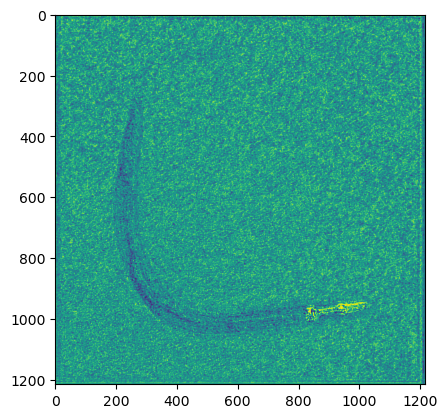

In [26]:
from matplotlib import pyplot as plt

plt.imshow(output[0, 0].detach().cpu().numpy())
plt.show()